## Introduction

This document describes the process of generating lane line paths from images and videos sourced from a camera mounted upon a vehicle. The lane line paths are modeled accurately using computer vision techniques, image transformations, and line fitting methods. 

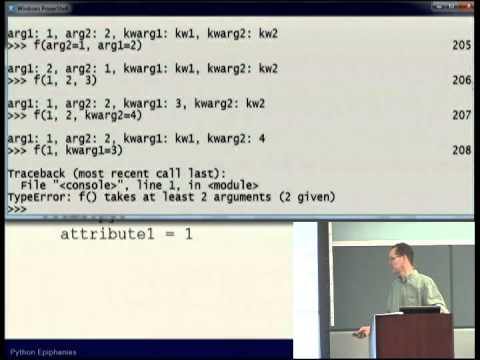

In [129]:
from IPython.display import YouTubeVideo
YouTubeVideo("Pi9NpxAvYSs")

## Setup

In [66]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

import numpy as np
import cv2
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from camera import Camera
from linefilter import LineFilter
from linefinder import LineFinder
from lanerenderer import LaneRenderer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Volumes/DATA/work/miniconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [124]:
def showImages(images, imgs_row, imgs_col, col_titles=None, cmap=None):
    fig, axes = plt.subplots(imgs_row, imgs_col, figsize=(35, 35),
                             subplot_kw={'xticks': [], 'yticks': []})

    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    if imgs_row == 1 and imgs_col == 1:
        axes.imshow(images[0], cmap=cmap)
    else: 
        i = 0
        for ax, image in zip(axes.flat, images):
            if i < imgs_col and col_titles is not None:
                ax.set_title(col_titles[i], fontsize=50)
            ax.imshow(image, cmap=cmap)
            i += 1

    plt.show()
    plt.close()
    
def drawText(img, region_w, region_w2, text, line):
    textSize, baseLine = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)    
    cv2.putText(img, text, (int((region_w + region_w2 - textSize[0]) / 2), (5 + textSize[1]) * line), cv2.FONT_HERSHEY_SIMPLEX, 1, (255., 255., 255.), 2)    

## Camera Lens Calibration and Image Undistortion

In order to perform object space calculations from projections taken from a photograph, the calculations would need to account for camera lens distortion. To determine the lens distortion properties, the camera is calibrated using a series of specialized images with a checkboard pattern to determine a set of lens distortion parameters. The distortion parameters can then be used to undistort a given image taken with the camera.

To generate distortion parameter set for the camera and undistort images, I used the following steps:

* Gather all of the internal corner points for all chessboard calibration images using cv2.findChessboardCorners() 
* Supply the corner points for all images and their associated grid index points to cv2.calibrateCamera()
* The result of the cv2.calibrateCamera() function is a set of lense distortion parameters.
* A given image can be undistorted by using the cv2.undistort() function with an image and the lens distortion parameters from the previous step.

Please see the ***calibrate*** method in **camera.py** for details on how I performed the calibration.

#### Calibration Undistortion Example

In [98]:
projectionPoints = [(620, 435), (658, 433), (1063, 694), (227, 705)]
camera = Camera((9,6), projectionPoints)
camimgs = glob.glob('./camera_cal/calibration*.jpg')
camera_images = []
for imgPath in camimgs:
    camera_images.append(mpimg.imread(imgPath))
camera_calibrations = camera.calibrate(camera_images)

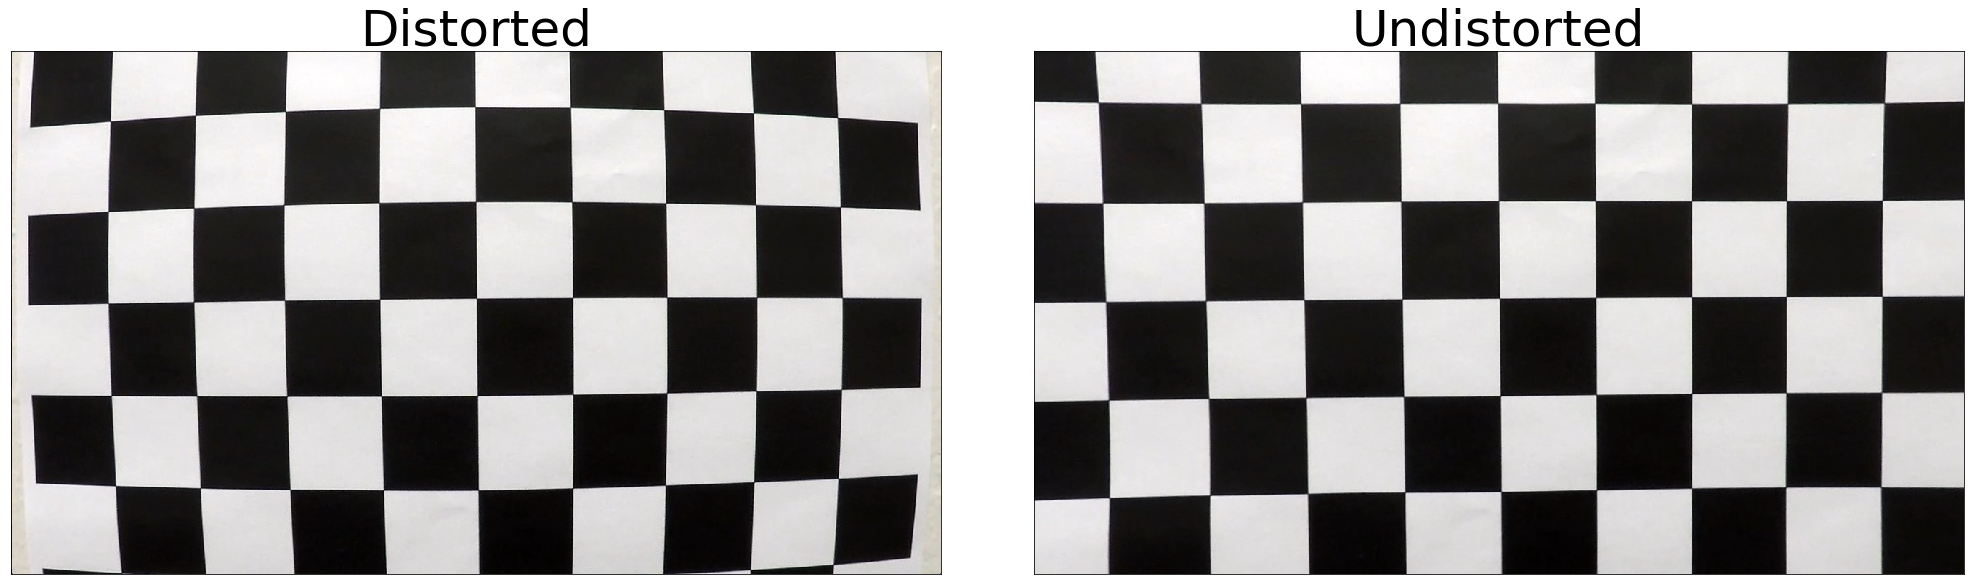

In [94]:
undistorted_imgs = []
distorted_imgs = []

for img, corners in camera_calibrations:
    distorted_imgs.append(img)
    undistorted_imgs.append(camera.undistort(camera.drawCorners(img, corners)))
    
arrImgs = np.array([distorted_imgs, undistorted_imgs])
showImages(arrImgs.T.flatten(), 1, 2, col_titles=["Distorted", "Undistorted"])   

## Lane Line Modeling Pipeline

The process for generating a model for lane lines from an image is summarized in the following steps:

* Apply camera undistortion transformation on the image
* Perform pixel filtering using color space transforms, gradients, and pixel selection using thresholds on different channels to generate.
* The selected pixel are converted to a 'score' from 0 to 1 as to their importance for line fitting and stored in a new image that represents the most likely lane line candidates.
* The lane line candidate image is transformed to a 'birds eye view' using a perspective transformation.
* The birds eye view image is processed to discover the left and right lane line pixels.
* The lane line pixels and their scores are used to model a best fit curve for the left and right lane lines using a least-squares regression algorithm.
* The line model equations are used to extrapolate curvature radius and lane offset position.
* The line models are used to render lane lines images in the birds-eye view coordinate space.
* The lane line images are transformed back into camera-space using the inverse of the camera perspective transformation.
* The lane line images are composited onto the orignal image to produce a final result image.

See the ***pipeline*** method in **pipeline.py** for the implementation of this process.

#### Undistortion Example

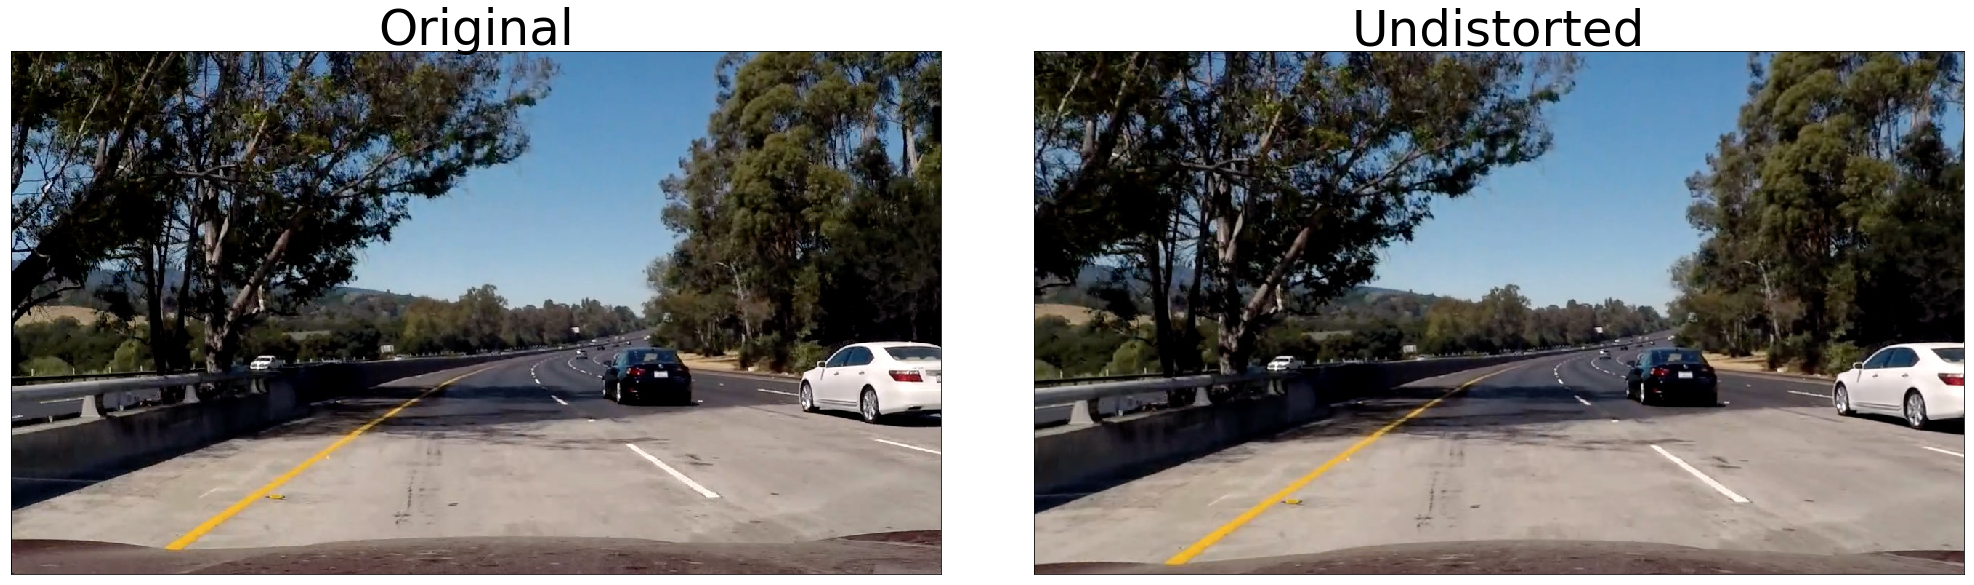

In [27]:
testimgPaths = glob.glob('./test_images/test5.jpg')
nextframe = mpimg.imread(testimgPaths[0])
img = camera.undistort(nextframe)
showImages([nextframe, img], 1, 2, col_titles=["Original", "Undistorted"])   

#### Color Space Transformations

I tried several color spaces for this projects, including RGB, HLS, HSV, YUV. I focused on using RGB, HLS, and HSV and ultimately used HSV since it offers the best combination of channels for extracting lane information. To isolate lane pixels with color information, the H channel with a low value range threshold, S channel with a low value range (0-20) and high value range (200+), and V channel range with medium to high value range (150+). The hue and saturation channels are the most invariant to contrast adjustments such as shadows so I focused on these as much as possible.

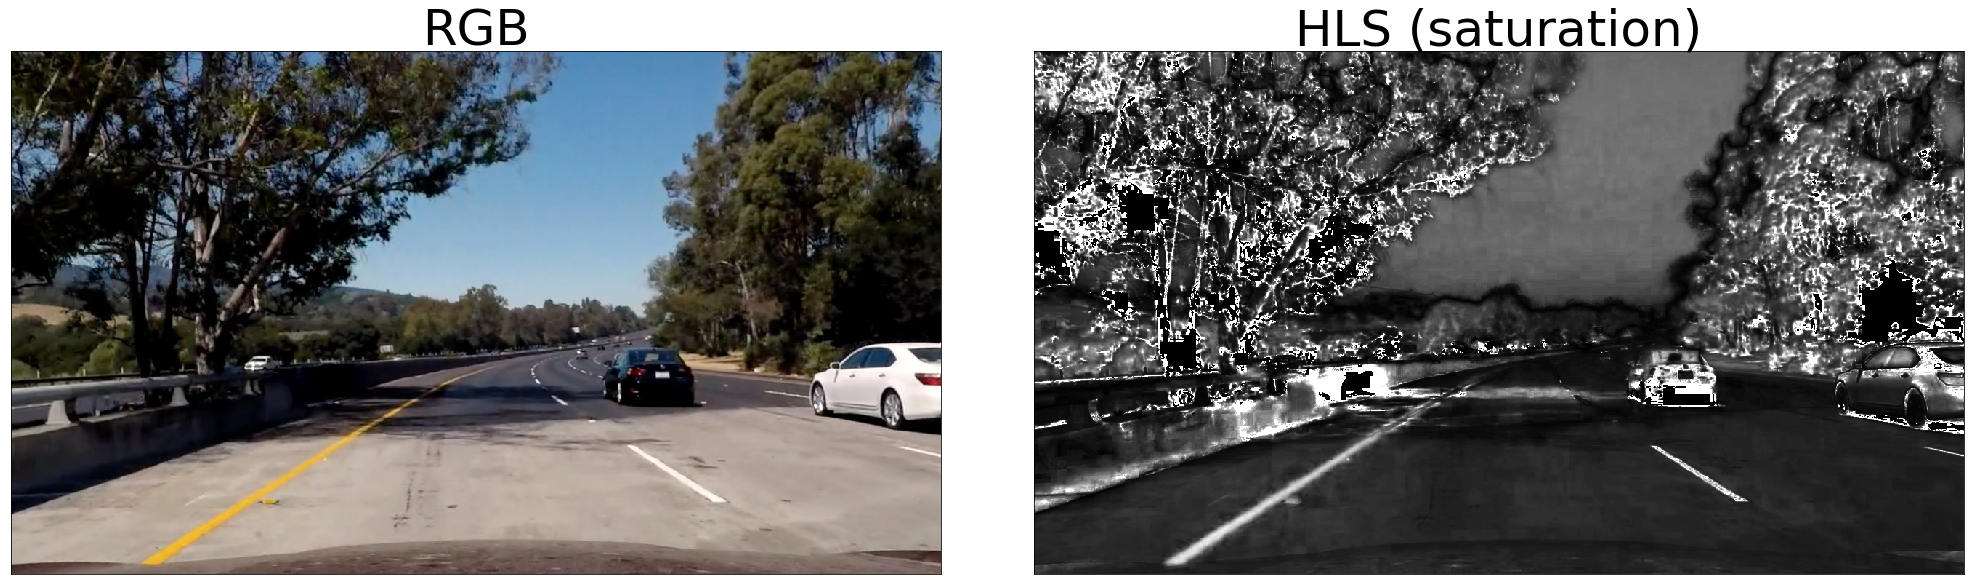

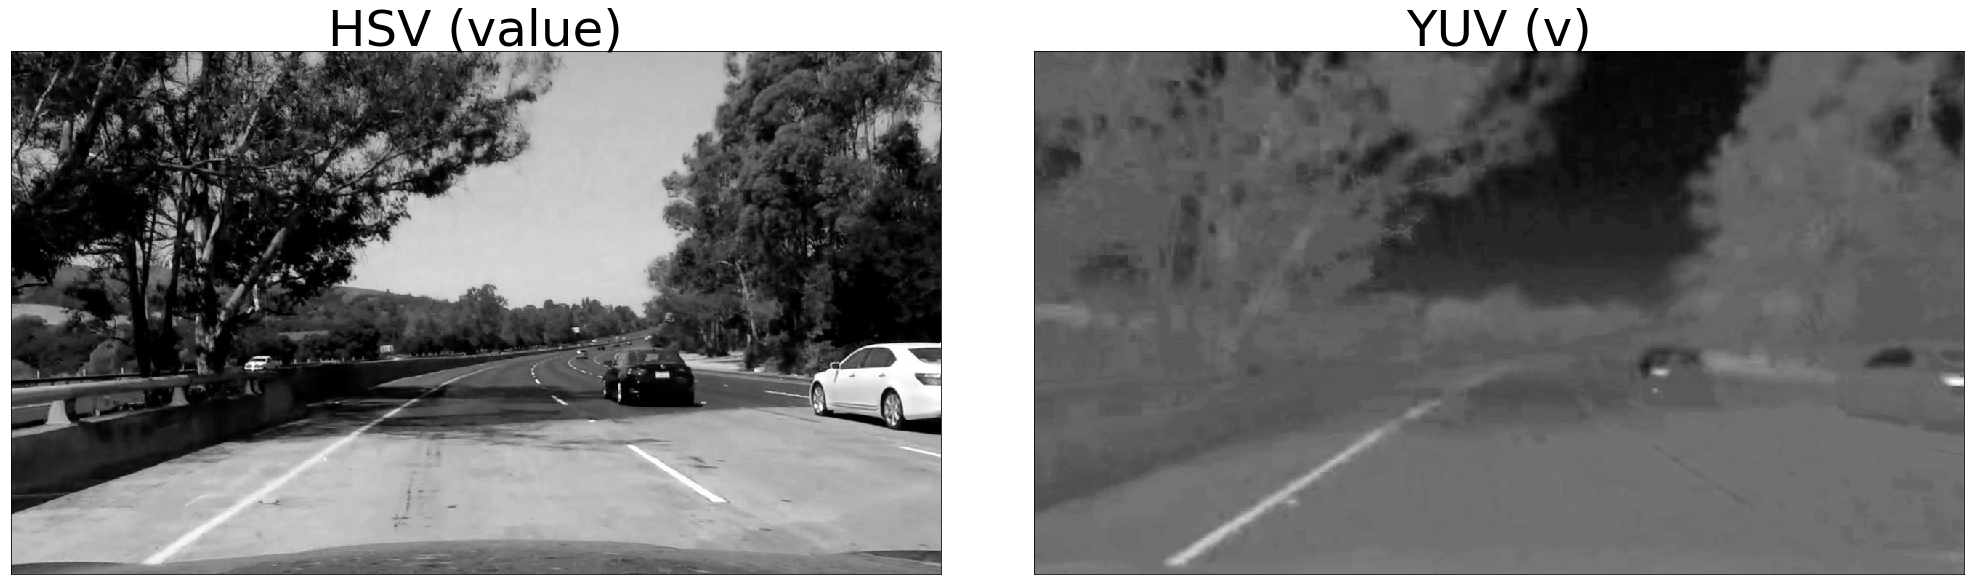

In [60]:
un_test_image = img
hsl_test_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hsv_test_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
yuv_test_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
showImages([img, hsl_test_image[:,:,2]], 1, 2, cmap='gray', col_titles=["RGB", "HLS (saturation)"])   
showImages([hsv_test_image[:,:,2], yuv_test_image[:,:,2]], 1, 2, cmap='gray', col_titles=["HSV (value)", "YUV (v)"])   

#### Gradients using Sobel Filter

I used Sobel filters to create a pixel selection process based on the image gradient for a channel. I experimented with X, Y, magnitude and direction angle threshold selection and I used a combination of these selections in the final pipeline. This gradients are helpful for finding the edges of the lane lines.


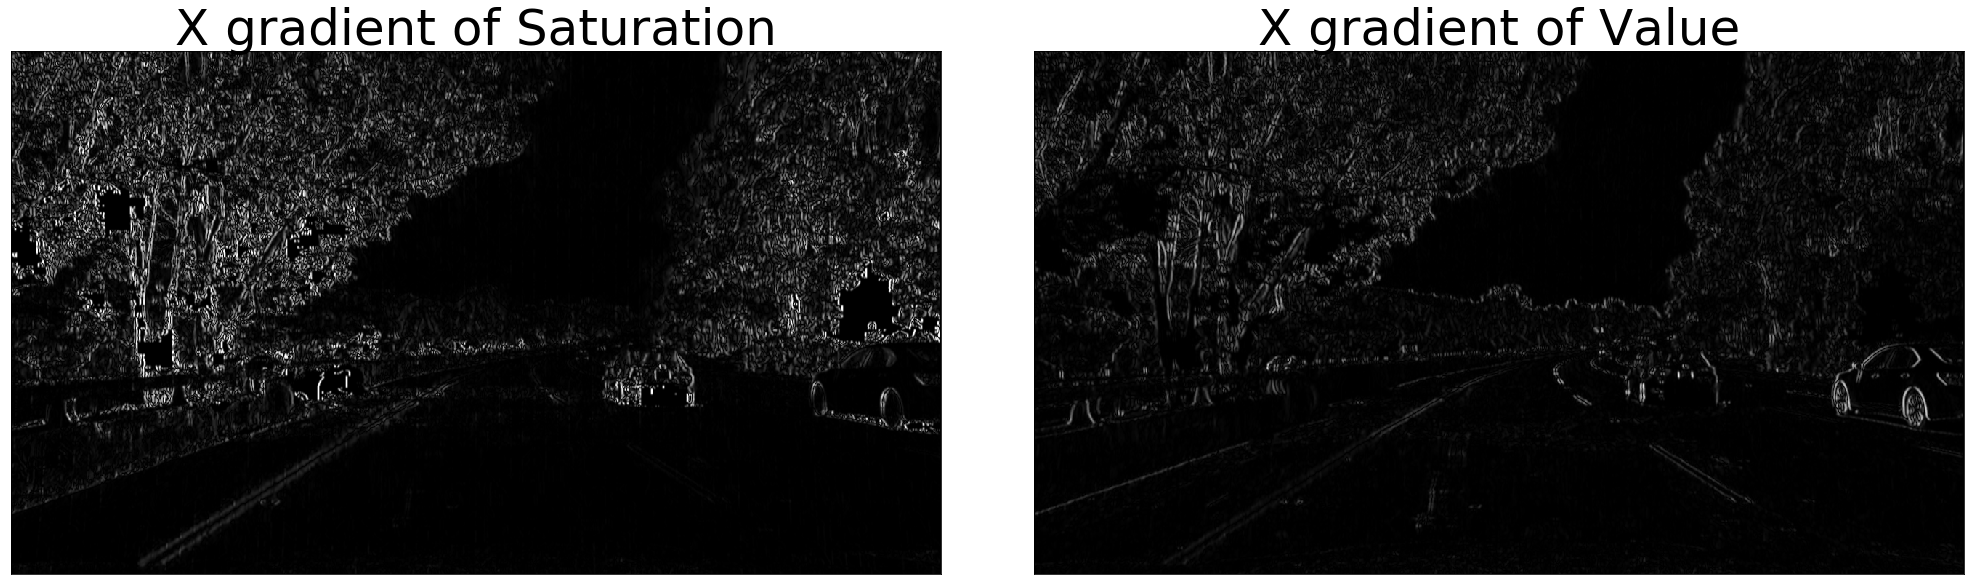

In [80]:
lf = LineFilter()
lf.source(hsv_test_image)
array = [lf.sobelX(1, 5), lf.sobelX(2, 5)]
showImages(array, 1, 2, cmap='gray', col_titles=["X gradient of Saturation", "X gradient of Value"])

#### Pixel Selection

Using a combination of color and gradient thresholding, I construct a new image of the most likely lane line pixels. The image is composed of the weighted sums of pixel masks from color and gradient thresholding operations. Contrary to the lectures, this final result is not a binary image mask. The values vary between 0-1 and represent the weight for the pixels in the line-fitting algorithms in the next steps. I found this to be more flexible way to experiment with line detection by weighting the contribution of the results of a particular pixel filter. For example, a filter could attempt to find pixels further off in the horizon line while another filter could focus on nearby lane pixels using different threshold parameters and their contribution to the line discovery can be tuned with different weights.

The **linefilter.py** file contains the ***LineFilter*** class which performs the thresholding operations. The combined line candidate image creation is found between lines 80-140 of **pipeline.py**.

In the below example, the 3 component filters are illustrated that select pixels with different thresholding operations. The combined image contains each filter mask result in a different channel in an RGB color space for visualization. These channels can then weighted to produce a final line candidate image.

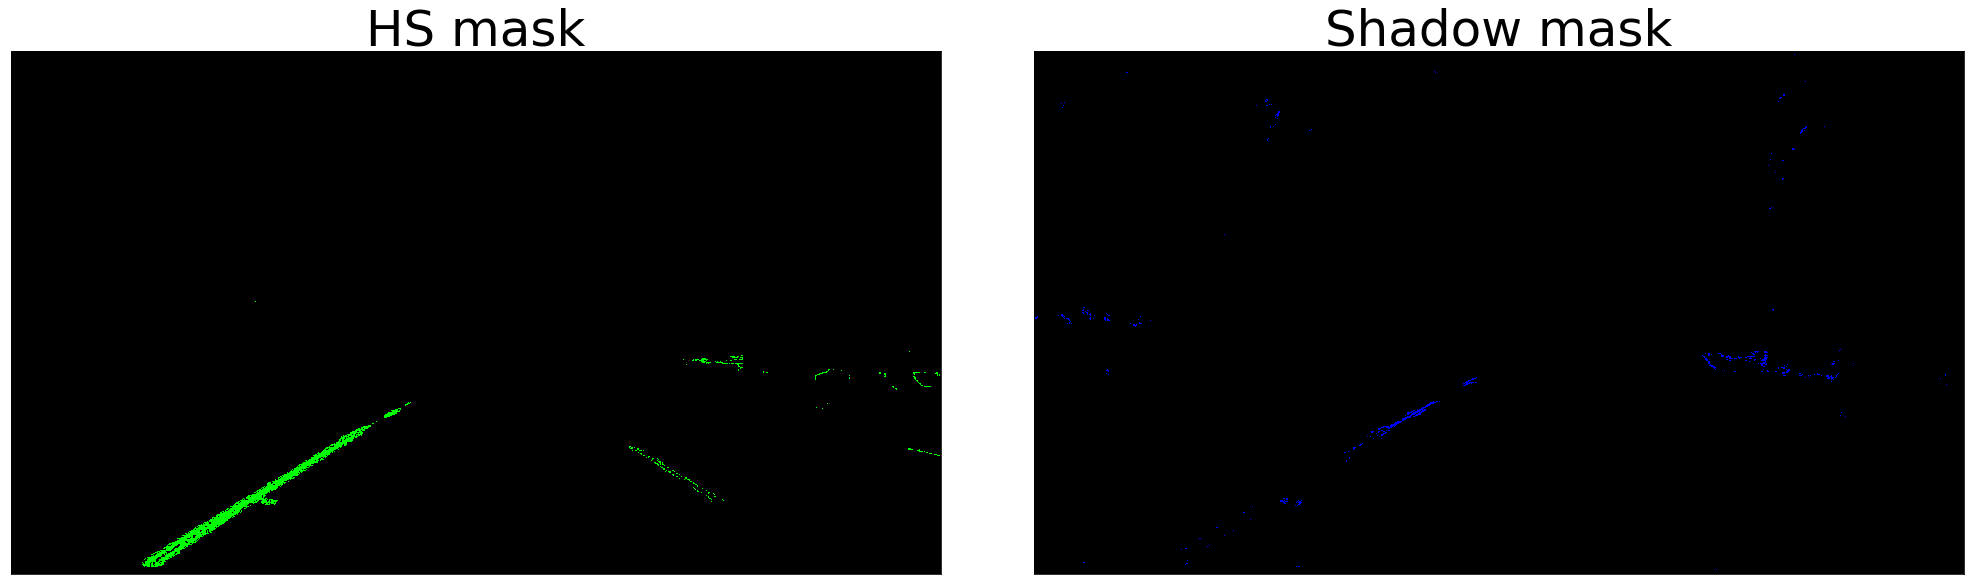

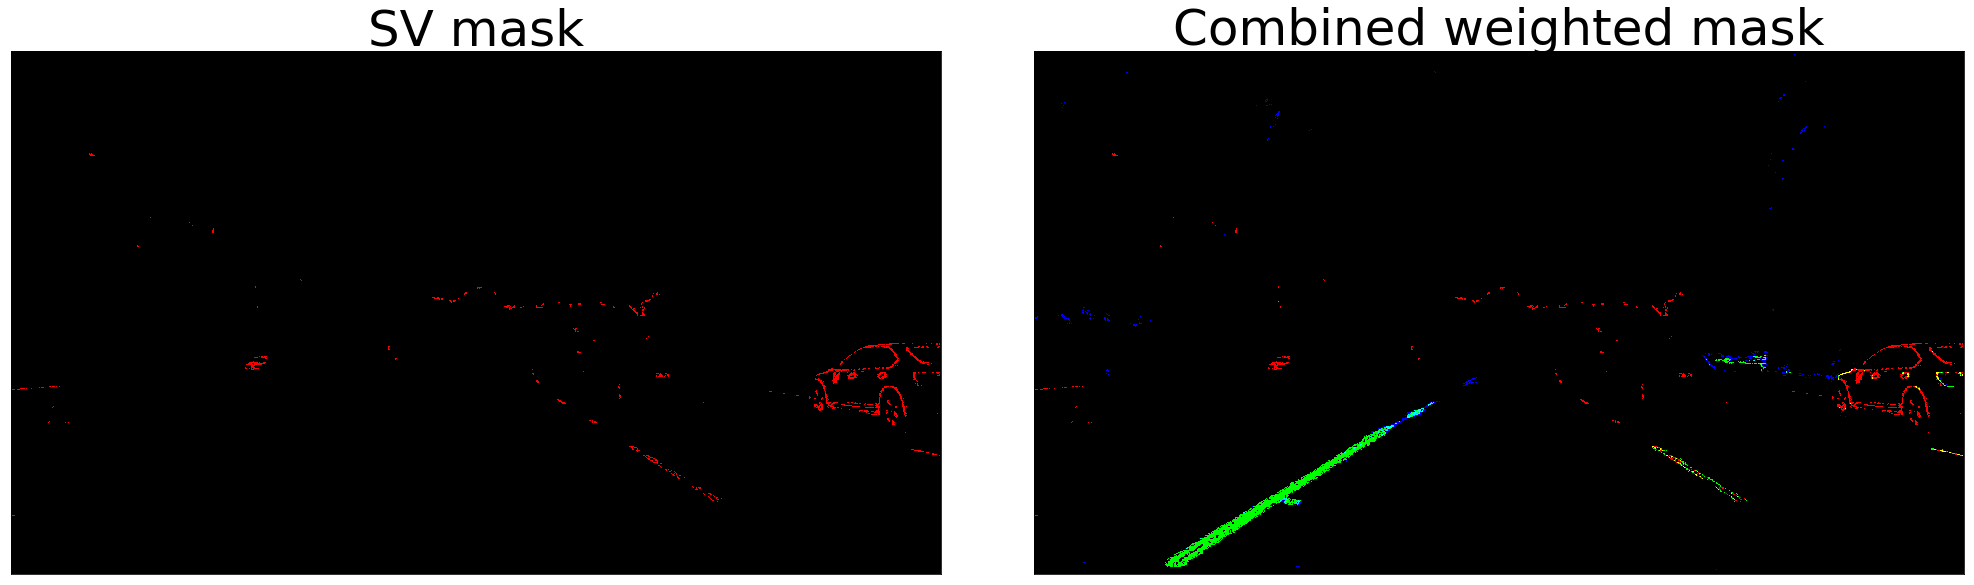

In [95]:
# Primary Hue and Saturation Filter (high saturation)
hs_high_mask = [lf.source(hsv_test_image).
            colorThreshold(0, (0, 30), kernel=5).
            colorThreshold(1, (100, 255), kernel=5).
            colorThreshold(2, (130, 255), kernel=5).
            sobelMagThreshold(1, (0.5, 255), 5).
            markLines()
        ]

# Primary Hue and Saturation Filter (low saturation)
hs_low_mask = [lf.source(hsv_test_image).
    colorThreshold(0, (0, 30), kernel=5).
    colorThreshold(1, (0, 30), kernel=5).
    colorThreshold(2, (200, 255), kernel=5).
    sobelMagThreshold(1, (1, 255), 5).
    markLines()
]

hs_mask = cv2.bitwise_or(np.array(hs_high_mask), np.array(hs_low_mask))

# Mid range saturation filter for shadowy regions
mid_mask = [lf.source(hsv_test_image).
    colorThreshold(0, (0, 30), kernel=9).
    colorThreshold(1, (70, 160), kernel=9).
    sobelMagThreshold(1, (2, 255), 5).
    colorThreshold(2, (100, 255), kernel=5).
    sobelMagThreshold(2, (1.5, 255), 5).
    markLines()
]

# Lightness only filter for white lines
sv_mask_1 = [lf.source(hsv_test_image).
    colorThreshold(2, (170, 255), kernel=3).
    sobelMagThreshold(2, (2, 255), 3).
    markLines()
]

#saturation filter for white lines
sv_mask_2 = [lf.source(hsv_test_image).
    colorThreshold(1, (0, 20), kernel=3).
    markLines()
]

sv_mask = cv2.bitwise_and(np.array(sv_mask_1), np.array(sv_mask_2))

selected_pixels = lf.combine([hs_mask[0], mid_mask[0], sv_mask[0]], useColors=np.array([[0, 1, 0], [0, 0, 1], [1,0,0]]))
hs_mask = lf.combine([hs_mask], useColors=np.array([[0, 1, 0]]))
mid_mask = lf.combine([mid_mask], useColors=np.array([[0, 0, 1]]))
sv_mask = lf.combine([sv_mask], useColors=np.array([[1, 0, 0]]))
selected_pixels_sum = np.sum(selected_pixels, axis=2) / 3

showImages([hs_mask, mid_mask], 1, 2, cmap='gray', col_titles=["HS mask", "Shadow mask"])
showImages([sv_mask, selected_pixels], 1, 2, col_titles=["SV mask", "Combined weighted mask"])

#### Bird's Eye View Transformation

The bird's eye view transformation is applied to the pixel candidate image using the cv2.getPerspectiveTransform() and cv2.warpPerspective() functions. For this transformation, I had to chose a series of points within an undistorted lane source image which represent the extents of the lane. The reference image chosen for this purpose is one with straight lane lines so that the projection transformation yields no curvature bias in the birds eye view. The projection also requires a target image size and coordinates for the transformed lane. I chose to use the same target image as the original image for consistency and a set of coordinates that would place the lane within the middle of the width with a lane width of 100 pixels.

The 1st example below shows the boundaries of the lane lines in the camera view and a transformed birds-eye view perspective. The 2nd row shows the perspective transformation applied to the pixel candidate image.

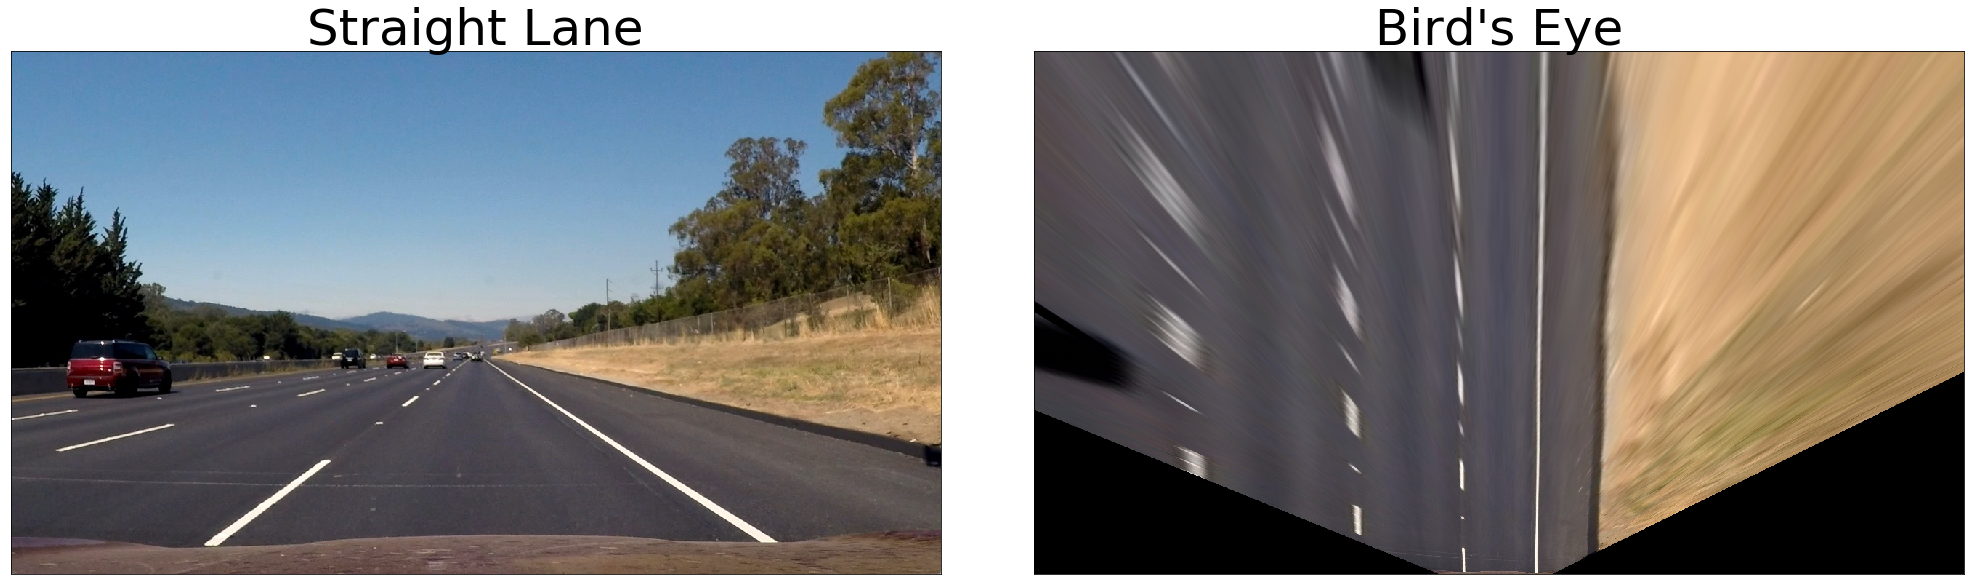

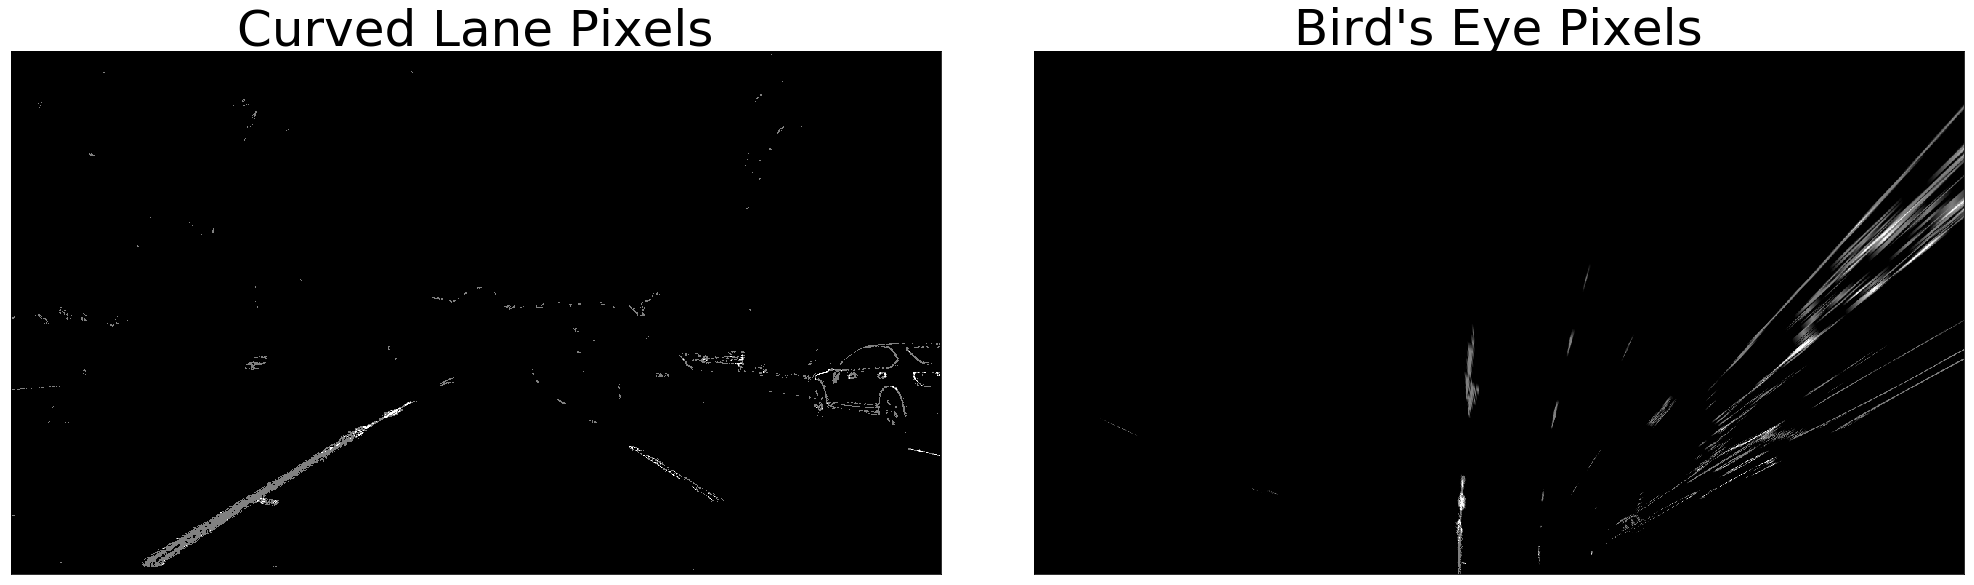

In [105]:
straightImgPaths = glob.glob('./test_images/straight_lines2.jpg')
straightImg = mpimg.imread(straightImgPaths[0])
straightBirdsEyeImg = camera.unproject(straightImg, 100, (1280, 720))
showImages([straightImg, straightBirdsEyeImg], 1, 2, col_titles=["Straight Lane", "Bird's Eye"])
birdsEye = camera.unproject(selected_pixels_sum, 100, (1280, 720))
showImages([selected_pixels_sum, birdsEye], 1, 2, cmap='gray', col_titles=["Curved Lane Pixels", "Bird's Eye Pixels"])

## Lane Line Search

The next step is to search the bird's eye pixel candidate image for the left and right lane line pixels. My search algorithm is adapted from the Udacity lectures and involves a search for groups of pixels using 2D convolutions along a vertical path across the image. The search begins at the bottom center of the image and continues vertically, using the higest concentration of pixel values from the candidate image to select the best path. There's various parameters that I use to tune this algorithm, such as the convolution filter size, the search width for the initial lane line from the center of the image, a search width and height for each incremental step, a search cut-off threshold if too many steps yield no valid results and a maximum search length. I tuned to these parameters empircally to provide the best results given the lane line dimensions while attempting to filter out noisy pixels near the lane lines.

This process generates two images, one for each lane line.

I experimented with attempting to search the entire length of the image for line candidate pixels in an effort to generate very long lane line models. While this did work 95% of the time, there were exception cases in which a small group of noisy incorrect candidate pixels that were not filtered out would be selected by this search algorithm, leading to incorrect lane line paths near. This would be likeliest for pixels furthest away from the camera due to distortion from the bird's eye transformation which increase the size of those further pixels. I chose to only search half the image to eliminate these outliers and improve the sample video quality consistenly across the entire video sample within the scope of this assignment.

The code for the filtering algorithm can be found in **linefilter.py**.

The example below shows the line lane images produced with green bounding boxes representing the search path chosen.

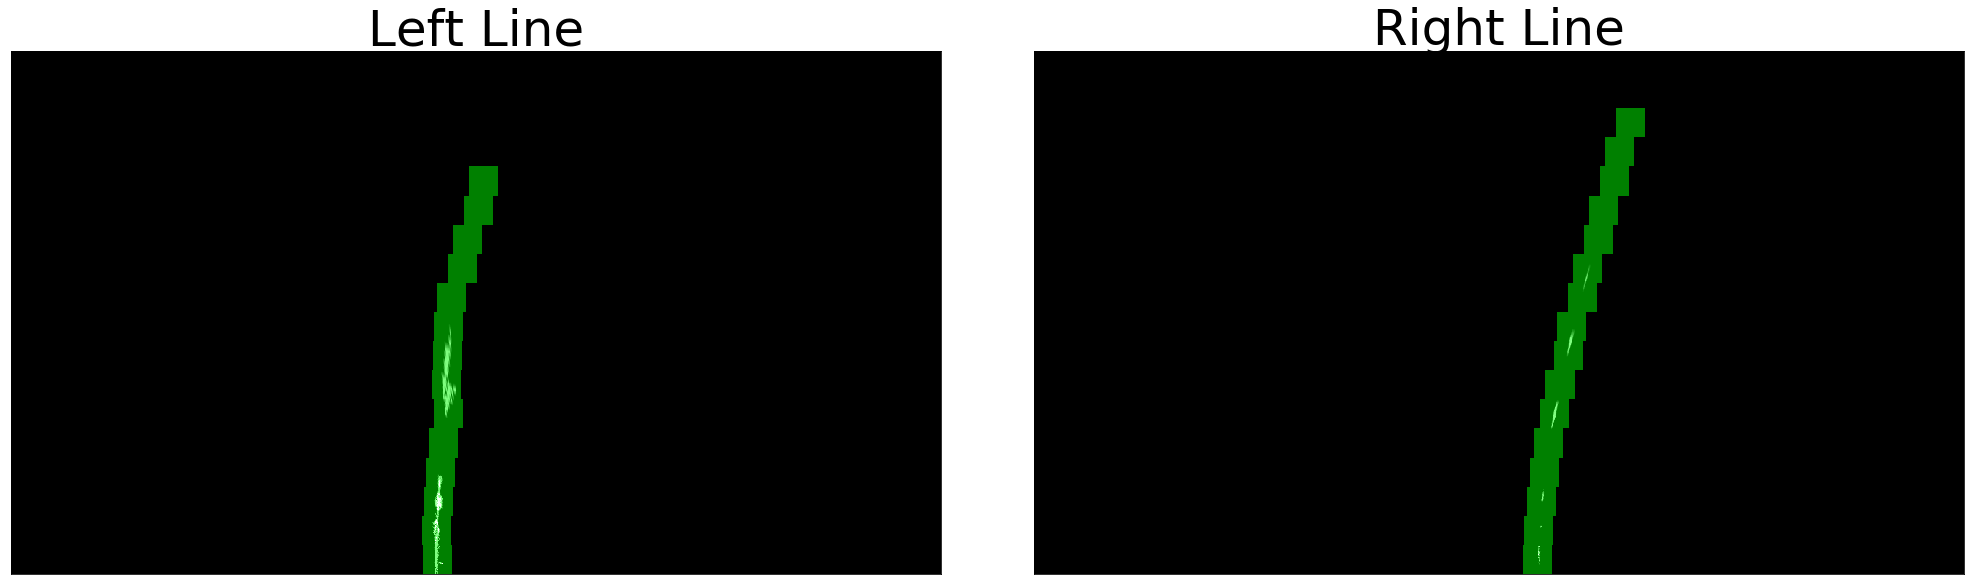

In [115]:
linefinder = LineFinder(75, 50, 10, 40, 40, 15, 200, 0)
left_lane_img_bounds, right_lane_img_bounds = linefinder.maskLines(birdsEye, drawBoundaries=True)
left_lane_img, right_lane_img = linefinder.maskLines(birdsEye, drawBoundaries=False)
showImages([left_lane_img_bounds, right_lane_img_bounds], 1, 2, cmap='gray', col_titles=["Left Line", "Right Line"])

#### Line Fitting and Rendering

The lane images generated by the search phase are now used to generate a model for the lines using a least-squares regression (numpy polyfit function). I chose a cubic polynomial as the model in an attempt to better fit the line across sharper curves. The regression inputs are the non-zero pixel locations as the X, Y data points and the pixel values as the weights for these data points. I also modified the weights with a bias to increase the importance of pixels based on their Y value. The pixels closer to the camera would have a higher weight contribution, forcing the line fitting to always pass through the pixels. These leads to better accuracy for the lane lines models.

I also experimented with data point augmentation to help model missing lane line pixels based on data from another line. Since lane lines are specified to be parallel to one another, data can be projected from one line lane to the other based on curvature and known lane line width. For example, if data from the left line is missing, while the right lane line is not, more data points are generated for the missing line using a projection along the normal vector of the curve from the data point in the direction of the missing line and at distance that matches the lane line width. This would help fill in areas in the other line that would follow a similar curved path from the known data.

After the line model is determined, a line model path is rendered by generating new pixel values along the line model (numpy polyval function).

The code for lane line fitting and rendering is found in **lanerenderer.py**.

In the following example, the lane line models for left and right lane lines are rendered in red. In the left image, unvisualized data points are generated to augment the left lane line based on curvature from the right lane line. This is illustrated by seeing a sharp curve near the end of the left lane line that matches the right lane line where there are no candidate pixels selected by the pixel filters.

50.1338677396 20.4486628363 29.6852049033 0.278081544761
346.798145394 230.606841299


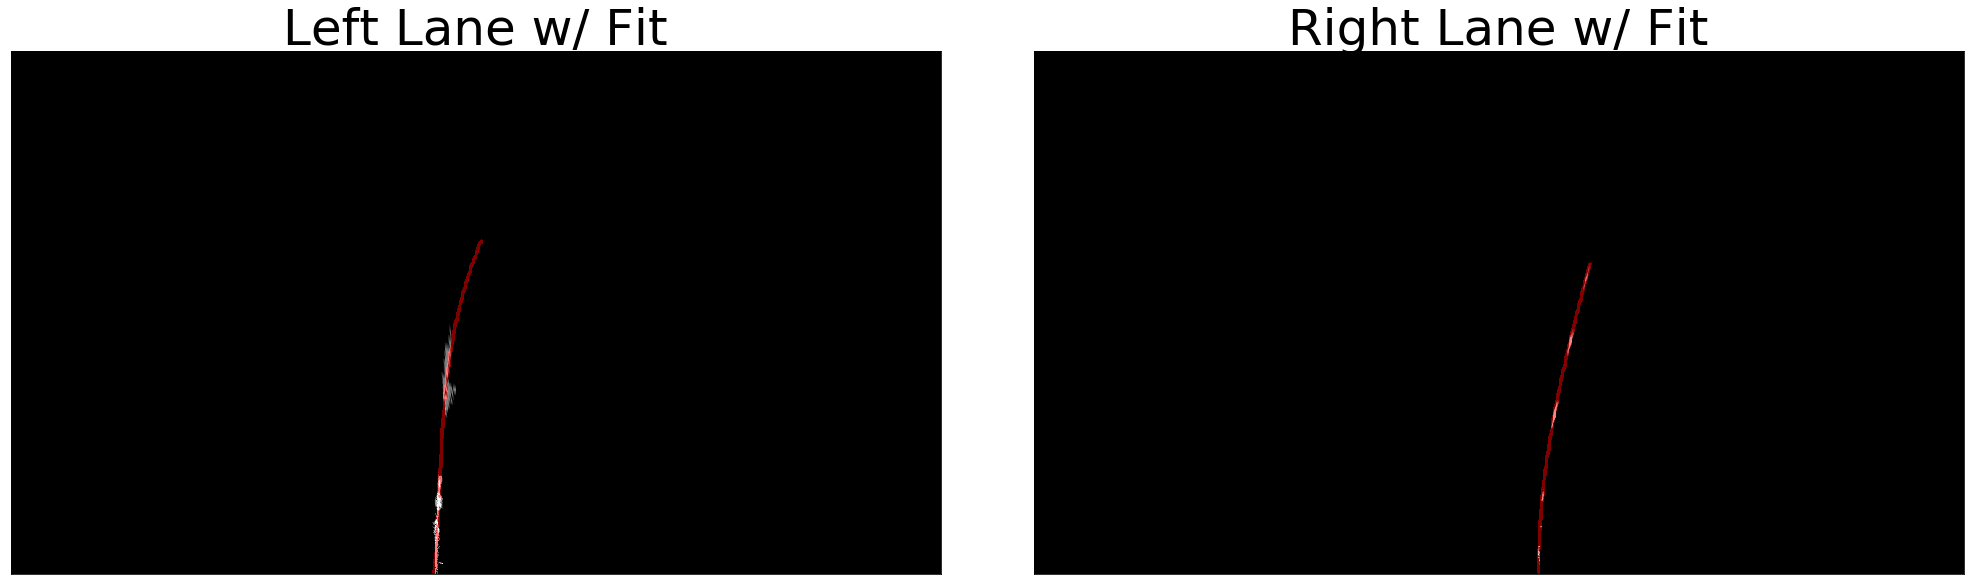

In [117]:
lanewidthPixels = 100
dashLaneLineLengthPixels = 30
lanerender=LaneRenderer(lanewidthPixels, 3.7/lanewidthPixels, 3./dashLaneLineLengthPixels)
lane = lanerender.findLaneFit(left_lane_img, right_lane_img, updateImages=False)
l_fit, r_fit = lane.lineFit
l_min, r_min = lane.minY
l_points = lanerender.generateLinePoints(left_lane_img.shape, l_fit, 5, minY=l_min)
r_points = lanerender.generateLinePoints(right_lane_img.shape, r_fit, 5, minY=r_min)
left_lane_line_img = lanerender.renderLinePoints(l_points, 
  (left_lane_img.shape[0], left_lane_img.shape[1], 3), cv2.merge((left_lane_img, left_lane_img, left_lane_img)),
  thickness=3
)
right_lane_line_img = lanerender.renderLinePoints(r_points, 
  (right_lane_img.shape[0], right_lane_img.shape[1], 3), cv2.merge((right_lane_img, right_lane_img, right_lane_img)),
  thickness=3
)

left_line_img = lanerender.renderLinePoints(l_points, 
  (left_lane_img.shape[0], left_lane_img.shape[1], 3),
  thickness=3, alpha=1.0, color=(0, 0, 255)
)
right_line_img = lanerender.renderLinePoints(r_points, 
  (right_lane_img.shape[0], right_lane_img.shape[1], 3),
  thickness=3, alpha=1.0, color=(255, 0, 0)
)
showImages([left_lane_line_img, right_lane_line_img], 1, 2, col_titles=["Left Lane w/ Fit", "Right Lane w/ Fit"])

#### Curvature Radius and Lane Position Offset

After the lane fitting is completed, there is enough information to determine the curvature radius and lane offset position. One important factor however is that the line has to be modeled in real-world measurement, such as meters, instead of pixels. In order to due this, the data point coordinates for each lines pixels are scaled by a certain factor to convert them to world-space coordinates. 

The scaling factor in the x dimension is 3.7 meters over the pixel lane width. The scaling factor for the y dimension is 3 meters over the 30 pixels. This second factor was determined by measuring the length of a lane line marker in pixels within the birds eye view (roughly 30 pixels) and using 3 meters as the length of the lane line in world space.

After the scaling factor is applied to the data points, a new line fit is calculated as described in the previous section. This lane line model is then used to determine the curvature radius.

The curvature radius is calculated using the following equations:

f(y) = x which equals the line fit polynomial
radius = ((1 + (f'(y), yScaledRef)^2))^1.5) / |f''(y)|

The y value used for the point of reference is the y value that represents the bottom of the image (the point closest to the camera which represents the current position of the vehicle).

The lane offset position measures the distance from the center of the lane. This is determined by calculating the X values of the left and right lanes closest the camera (where Y = max height of image) using the pixel-space lane fit polynomials. The midpoint between these values represents the lane center in pixel space. Since the camera is assumed to be mounted in the center of the vehicle, half the image width represents the position of the camera in pixel space. By subtracting half of the image width from the X lane line midpoint position, an offset of the camera from the lane line center is thus determined in pixel space, which is then scaled by the world-space x dimension factor to determine the lane offset in meters.

The code for this is found **linerenderer.py** at lines 40-47 and 184-203.

In [120]:
print(lane.radius, "m")

346.798145394 m


In [121]:
print(lane.centerOffset, "m")

0.0544928352807 m


#### Projecting Lane Lines onto Original Image

Now that the lane line models are known and lane lines can be rendered from these models, they can be projected back onto the original image to illustrate accuracy of the models in camera space.

This is a simple operation of rendering the lines in pixels space in birds eye view and then performing an inverse perspective transformation back to camera space using the cv2.getPerspectiveTransform() and cv2.warpPerspective() functions. To inverse the transformation, the source and destination project points are reversed.

I also generate a lane region by generating a filled polygon using the lane line models to generate points along the left and right edges and connecting the end points of each line together. This is rendered in birds eye view and transformed it to camera space as described above.

These images (left lane, right lane, lane region) are composited on the original image using alpha blending.

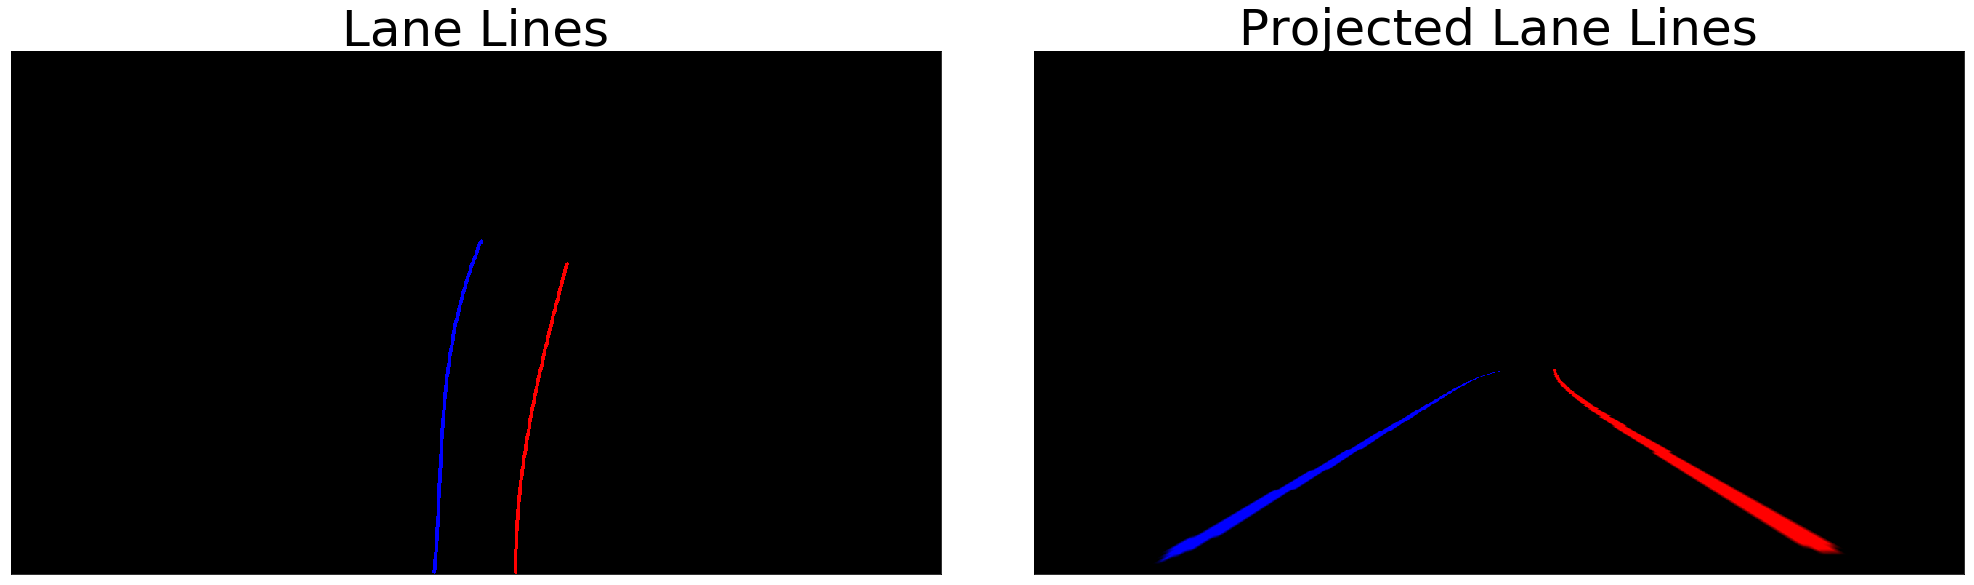

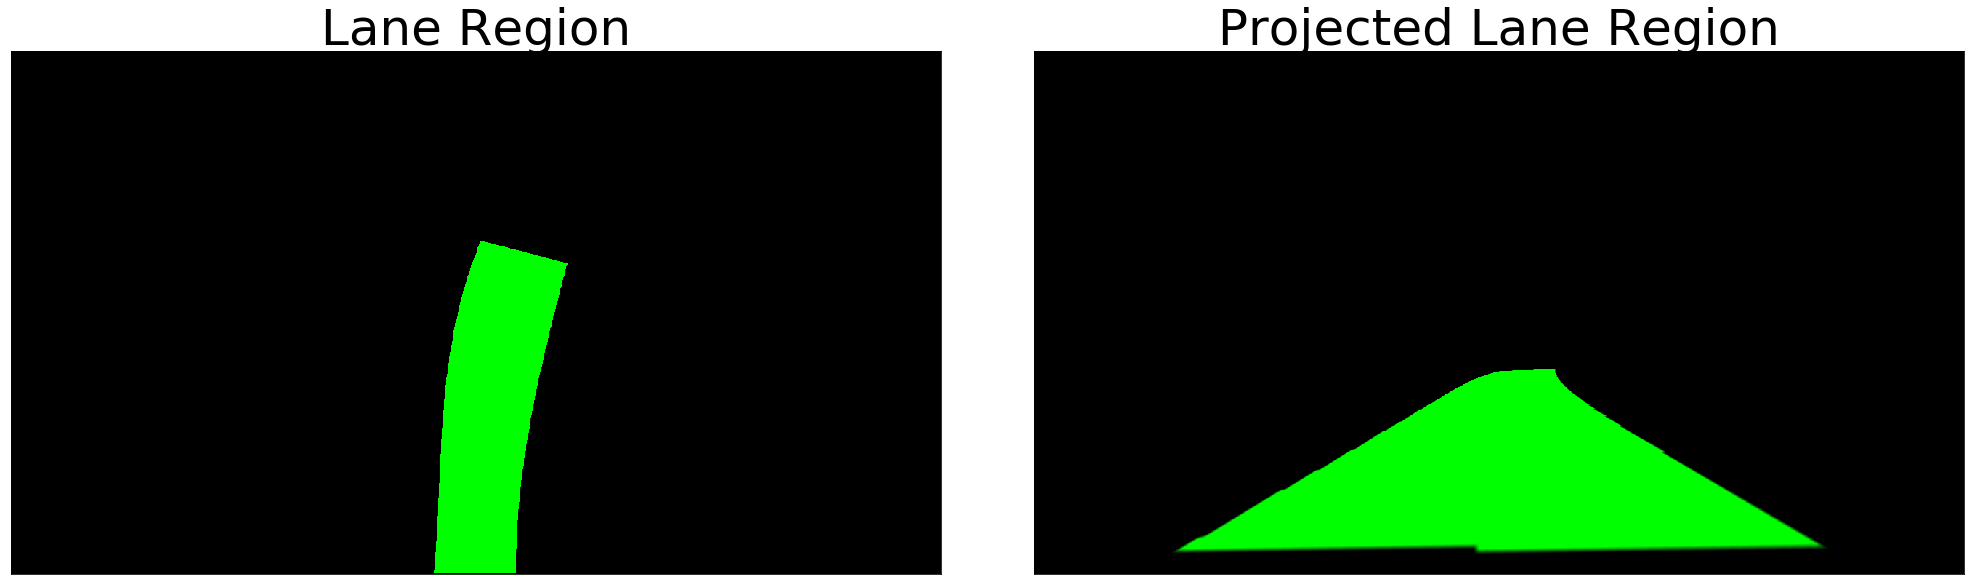

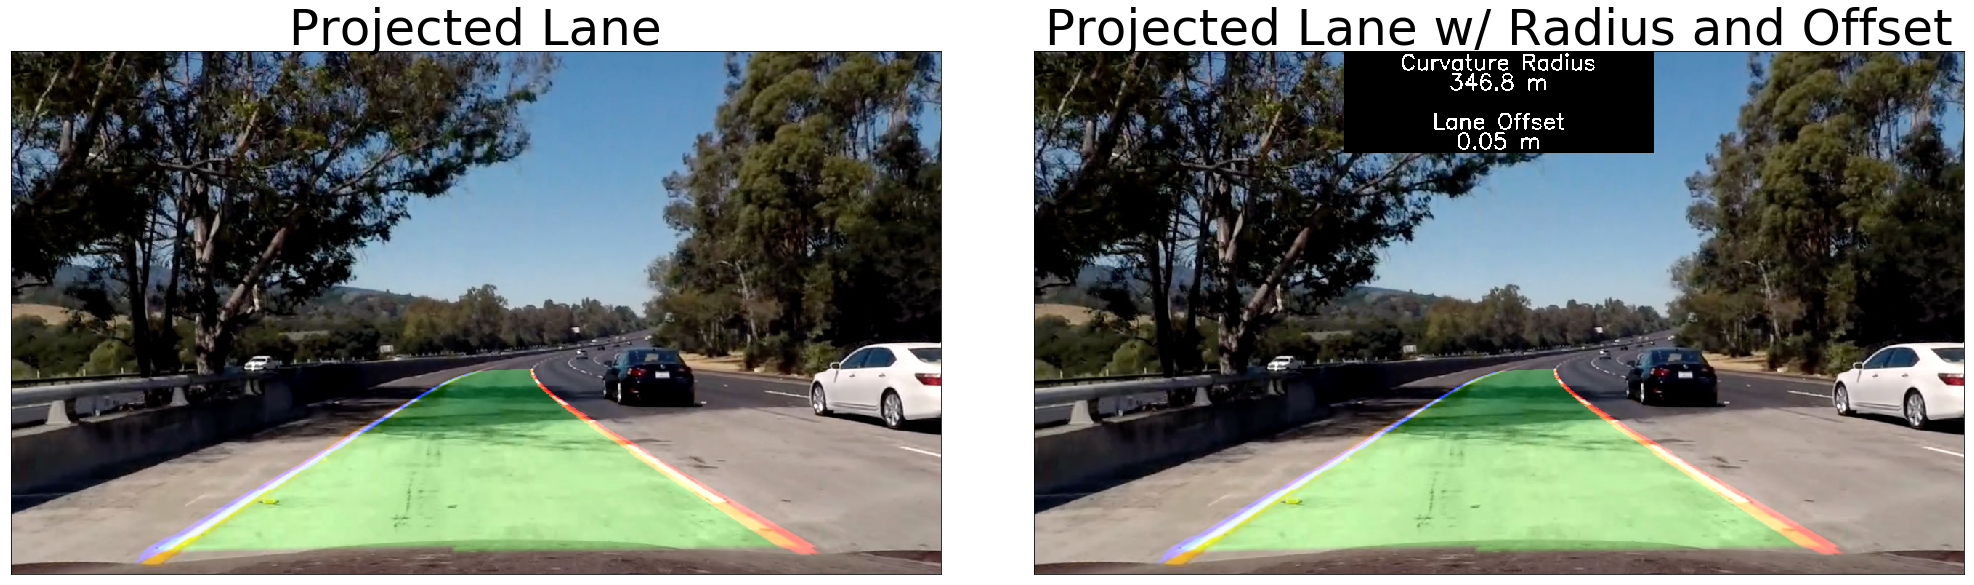

In [127]:
left_line_img = lanerender.renderLinePoints(l_points,
  (left_lane_img.shape[0], left_lane_img.shape[1], 3),
  thickness=3, alpha=1.0, color=(0, 0, 255)
)
right_line_img = lanerender.renderLinePoints(r_points,
  (right_lane_img.shape[0], right_lane_img.shape[1], 3),
  thickness=3, alpha=1.0, color=(255, 0, 0)
)

merged_lane_line_img = cv2.bitwise_or(left_line_img, right_line_img)

r_points_reversed = r_points[::-1]
center_points = np.concatenate((np.array(l_points),
                               np.array(r_points_reversed)), axis=0
              )
center_lane_img = lanerender.renderLinePoints(center_points,
  (left_lane_img.shape[0], left_lane_img.shape[1], 3), color=(0.,255.,0.), thickness=3, closed=True
)

merged_lane_line_img_projected = camera.unproject(merged_lane_line_img, lanewidthPixels, (1280, 720), invert=True)
center_lane_img_projected = camera.unproject(center_lane_img, lanewidthPixels, (1280, 720), invert=True)

showImages([merged_lane_line_img, merged_lane_line_img_projected], 1, 2, col_titles=["Lane Lines", "Projected Lane Lines"])
showImages([center_lane_img, center_lane_img_projected], 1, 2, col_titles=["Lane Region", "Projected Lane Region"])

combined_projected_lane_img = center_lane_img_projected
overlay_lane_img = cv2.addWeighted(un_test_image, 1, combined_projected_lane_img, 0.25, 0.0) # overlay the orignal road image with window results
overlay_lane_img = cv2.addWeighted(overlay_lane_img, 1, merged_lane_line_img_projected, 1.0, 0.0)

#draw curvature and offset
textSize, baseLine = cv2.getTextSize("Curvature Radius", cv2.FONT_HERSHEY_SIMPLEX, 1, 1)
text_h = textSize[1] + 5

final_img = overlay_lane_img.copy()

region_w = int(img.shape[1] / 3)
region_w2 = int(img.shape[1] * 2 / 3)
cv2.rectangle(final_img, (region_w, 0), (region_w2, text_h * 5 + 5), (0., 0., 0.), cv2.FILLED)

drawText(final_img, region_w, region_w2, "Curvature Radius", 1)
drawText(final_img, region_w, region_w2, "{:.1f} m".format(lane.radius), 2)
drawText(final_img, region_w, region_w2, "Lane Offset", 4)
drawText(final_img, region_w, region_w2, "{:.2f} m".format(lane.centerOffset), 5)

showImages([overlay_lane_img, final_img], 1, 2, col_titles=["Projected Lane", "Projected Lane w/ Radius and Offset"])


## Final Notes

The lane lines generated across frames of a video can have some variability due to continual changes in the detected pixels. This variability will lead to wobbling lines, especially in cases near the camera when the dashed lane markers disappear underneath the car. To smooth the lines across frames, the birds-eye candidate line pixels are queued from up to X number of previous frames (I choose 5 for this project). The weighted sum of the pixels from these historical frames plus the current frame are then used for lane line fitting. This provides additional data points for the line fitting algorithm to model a smoother curve across the time dimension.

Most of the complexity of the project was within the pixel filtering and lane line search. It was difficult to tune the filters precisely to find pixels accurately across different regions of illumination and ground place coloring while also filtering out irrelevent pixels. Also, the line search algorithm had to be tuned to be resistant to following an incorrect line path.

Here were some problem cases and some solutions:

* Tan colored cement and yellow lines (solved by tuning saturation filters)
* Shadowy regions under the trees (solved by tuning saturation filter, augmenting data with white line data)
* Black car driving next to car affecting the line search (solved by tuning the search algorithm to only consider pixels close to the center of the image as the seed positions for the lane lines)
* Noisy pixels further down the road affecting line search (solved by stopping the search algorithm after a certain distance)

In terms of failure cases, this model still will fail in cases of lower illumination such as underpasses where both lane line are obscured by shadows. More tuning of the filters to be resiliant in lower contrast areas is needed to solve this. Also highly curvy roads would break the line search algorithm since it uses a simplified search algorithm that does not account for finding near-horizontal lines. The algorithm only continues to search in the vertical direction and doesn't fully consider searches along a horizontal direction only. Other failure cases would be improperly tracking lanes due to conflicting road markings, such as improper lane lines found in construction areas.
